In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import ast

# logging config
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# read processed data
df = pd.read_csv('../data/twitter/processed.csv', encoding='latin-1')
df['processed_text'] = df['processed_text'].apply(lambda x: ast.literal_eval(x))

In [3]:
tokenized_sentences = list(df['processed_text'])

In [4]:
# train the model
# change vector size, epochs, negative samples

models = {}
vector_sizes = [128, 256, 300]
windows = [5, 10, 15]
negative_samples = [10, 15, 20]

# train the model using different parameters
for v in vector_sizes:
    for w in windows:
        for ns in negative_samples:
            model = Word2Vec(
                tokenized_sentences,
                vector_size=v,
                window=w,
                min_count=1,
                sg=1,
                epochs=10, # fix number of epochs at 10
                negative=ns,
                workers=12
            )

            # save each model in a dictionary, then pick best one later
            models[(v, w, ns)] = model

2025-08-19 13:40:06,507 : INFO : collecting all words and their counts
2025-08-19 13:40:06,509 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-08-19 13:40:06,532 : INFO : collected 19072 word types from a corpus of 130258 raw words and 10000 sentences
2025-08-19 13:40:06,533 : INFO : Creating a fresh vocabulary
2025-08-19 13:40:06,563 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 19072 unique words (100.00% of original 19072, drops 0)', 'datetime': '2025-08-19T13:40:06.563441', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-08-19 13:40:06,563 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 130258 word corpus (100.00% of original 130258, drops 0)', 'datetime': '2025-08-19T13:40:06.563441', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25

In [5]:
# save the trained models in case we need to use it again
for k in models.keys():
    vector_size, window, negative_samples = k
    models[k].save(f'./models/word2vec/skipgram_{vector_size}_{window}_{negative_samples}.model')

2025-08-19 13:44:58,262 : INFO : Word2Vec lifecycle event {'fname_or_handle': './models/word2vec/skipgram_128_5_10.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-08-19T13:44:58.262784', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-08-19 13:44:58,265 : INFO : not storing attribute cum_table
2025-08-19 13:44:58,304 : INFO : saved ./models/word2vec/skipgram_128_5_10.model
2025-08-19 13:44:58,306 : INFO : Word2Vec lifecycle event {'fname_or_handle': './models/word2vec/skipgram_128_5_15.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2025-08-19T13:44:58.306381', 'gensim': '4.3.3', 'python': '3.12.1 (tags/v3.12.1:2305ca5, Dec  7 2023, 22:03:25) [MSC v.1937 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'saving'}
2025-08-19 13:44:58,307 : INFO : not stori

## Analysis

### Nearest Neighbours for selected words

In [10]:
selected_words = [
    'sad',
    'chocolate',
    'chemistry',
    'month',
    'news'
]

for params, model in models.items():
    vector_size, window, negative_samples = params
    print(f'Model parameters are: vector size = {vector_size}, window size = {window}, negative samples = {negative_samples}')
    for word in selected_words:
        print(f'Word is: {word}')
        print(model.wv.most_similar(word))
        print("*" * 30)

    print("-" * 50)
    print()

Model parameters are: vector size = 128, window size = 5, negative samples = 10
Word is: sad
[('worried', 0.8833690881729126), ('upset', 0.864315927028656), ('shit', 0.8472289443016052), ('bear', 0.8465982675552368), ('horrible', 0.8456434607505798), ('awkward', 0.8398671746253967), ('attractive', 0.8385142683982849), ('true', 0.8381198644638062), ('shes', 0.8368372917175293), ('fucking', 0.8366029262542725)]
******************************
Word is: chocolate
[('rained', 0.9779238700866699), ('dryer', 0.977541446685791), ('makeup', 0.9773772954940796), ('activity', 0.9769424200057983), ('drug', 0.9767533540725708), ('prom', 0.976654052734375), ('timing', 0.9766209125518799), ('waffle', 0.9762614965438843), ('washed', 0.9762054085731506), ('cloud', 0.975761353969574)]
******************************
Word is: chemistry
[('proper', 0.9874882102012634), ('towards', 0.9869076013565063), ('driver', 0.9868116974830627), ('recommendation', 0.9867666959762573), ('sunbathing', 0.986625611782074), 

Similar words sometimes do not make sense, like for chocolate.

Based on qualitative analysis on the chosen words, best model parameters are: vector size = 300, window size = 5, negative samples = 15

### Visualization of PCA embedding space

In [13]:
model = models[(300, 5, 15)]

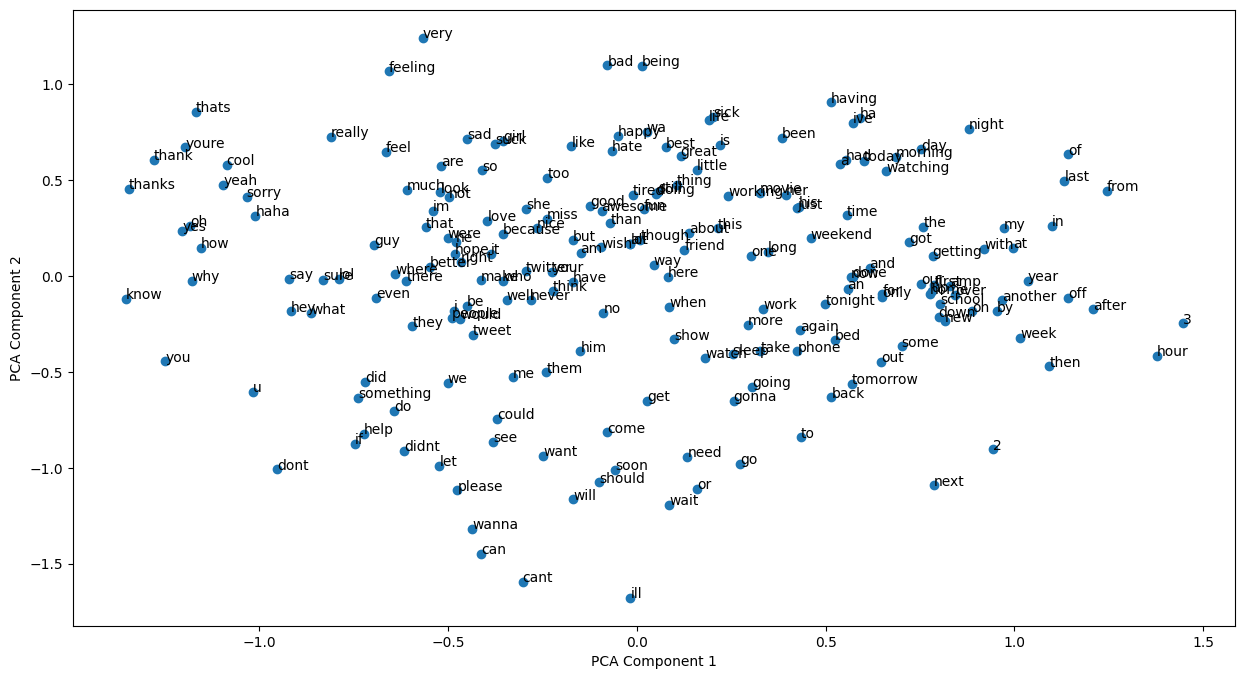

In [14]:
words = list(model.wv.index_to_key[0:200])
embeddings = model.wv[words]

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(15, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o')

for i, word in enumerate(words):
    plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=10)


plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

There some words that are similar and close to each other, like 'thank' and 'thanks'.

The words seem to take up most of the 2 dimensional space.